# __SpringBoard Capstone Project 1: Machine Learning__
## __(Cervical Cancer Dataset)__

__Written by: Sofy Weisenberg__<br>
__Date: 02/18/20__


__Step 1: Importing the Dataset and Data Preparation__<br>
Import the original dataset and perform data wrangling steps to prepare data for analysis (for details on these steps, see: https://github.com/s-weisenberg/Springboard/blob/master/Capstone_Project_1/Capstone1_Data_Wrangling.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df = df.replace('?', np.nan)
for column, values in df.iteritems():
        df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'], axis=1)
df = df.fillna(df.median())
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


__Step 2: Normalizing and Splitting the Data__<br>
For many of the machine learning algorithms to be implemented here, scaling the data is an important preprocessing step. Many of the variables, including the target y, are already in the [0,1] range. However, several require normalization to this range. This helps improve classification decisions that are based on the Euclidean distance between observations.

The dataframe also needs to be split into the feature and target data and some data must be set aside for model validation.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# define default random state so that all future random actions will be repeatable
random_state = np.random.RandomState(0)

# define scaler, default feature_range=(0, 1)
scaler = MinMaxScaler()

# split the data into features and target 
X = df.drop(['Biopsy'],axis=1)
y = df['Biopsy']

# fit and transform scaler in one step for X, y is already normalized
X_normalized = scaler.fit_transform(X)

# perform stratified test-train split to hold off 25% of normalized data for model validation
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, stratify=y, random_state=random_state)

In [3]:
pd.DataFrame(X_normalized).describe()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,...,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,0.194655,0.055987,0.317970,0.205234,0.143357,0.032466,0.012062,0.686480,0.067844,0.096737,...,0.001166,0.002331,0.029138,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282
std,0.119689,0.060917,0.126904,0.127362,0.350641,0.109747,0.059739,0.464194,0.118901,0.295771,...,0.034139,0.048252,0.100848,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.098592,0.037037,0.227273,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.169014,0.037037,0.318182,0.181818,0.000000,0.000000,0.000000,1.000000,0.016667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.267606,0.074074,0.363636,0.272727,0.000000,0.000000,0.000000,1.000000,0.066667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


__Step 3: Fitting a ML model__<br>
As a start, a few traditional ML models will be fit to the data. Later, a deep learning model will be implemented for comparison. To start off, a logistic regression model will be fit to the data.

Hyperparameter tuning is be accomplished via grid search coupled with 5-fold cross-validation. Several hyperparameters are considered, and the parameters' performance is evaluated using the F1 score, which takes into account both precision and recall. Though the F1 score assumes equal weight for precision and recall (when in reality recall/sensitivity is of higher priority), since no other weighting scheme is known a priori, it is an acceptable default. As a note: other classifier scoring metrics (e.g. log loss, Brier score loss, ROC AUC) were also tried and gave very similar hyperparameter optimizations. 

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

logistic = LogisticRegression(random_state=random_state)

# define hyperparameter options
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
class_weight = [{1:0.7, 0:0.3}, {1:0.8, 0:0.2}, {1:0.9, 0:0.1}, {1:0.95, 0:0.05}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=logistic,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s


Best Score (F1): 0.7536
Best Params:  {'C': 0.01, 'class_weight': {1: 0.9, 0: 0.1}, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    2.6s finished



Note: Trying 'recall' as the scoring method, which could be justified as we wish to reduce false negatives, gives a perplexing optimization. It reaches a recall score of 1 (perhaps for some trivial combination of hyperparameters?). The resulting combination does not generalize well at all to the test set, so perhaps a case of overfitting?.

__Step 4: Selecting Final Model Evaluation Criteria__<br>

From https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/:

Reviewing both precision and recall is useful in classification problems where there is an imbalance in the observations between the two classes (see https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432). Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1). This is indeed the case for this dataset.

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives. Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1.

Therefore, the precision-recall performance as well as the log loss, another common classifier performance metric, will be examined for the final logistic regression model. These metrics can later be used to compare various ML models.

In [5]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import fbeta_score

model = grid_result.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss_model = log_loss(y_test, y_proba)
fbeta = fbeta_score(y_test, y_pred, beta=2)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss_model))

Average precision-recall score: 0.49
Log loss: 0.63


In [6]:
from sklearn.metrics import classification_report

target_names = ['Biopsy = 0', 'Biopsy = 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Biopsy = 0       0.98      0.98      0.98       201
  Biopsy = 1       0.67      0.71      0.69        14

    accuracy                           0.96       215
   macro avg       0.82      0.84      0.83       215
weighted avg       0.96      0.96      0.96       215



Text(0, 0.5, 'Precision')

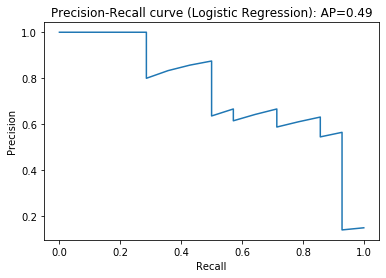

In [7]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(recall, precision)
plt.title('Precision-Recall curve (Logistic Regression): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')


__Step 5: Evaluating Additional ML Models__<br>

Additional traditional ML classifier models may be fit to the data:
- Support Vector Classifier (SVC) - an application of support vector machine (SVM)
- Random Forest Classifier - decision tree ensemble method using bootstrapping
- k Nearest Neighbors Classifier (k-NN)
- A deep learning (neural network) model using Keras will also be implemented and compared.

__Support Vector Classifier (SVC)__<br>

In [8]:
from sklearn.svm import SVC

svc = SVC(probability = True, random_state=random_state)

# define hyperparameter options
param_grid = {'C': [0.1, 1, 100, 1000, 10000],
              'gamma': [1, 0.1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf']} 

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=svc,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Score (F1): 0.7341
Best Params:  {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 110 out of 125 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.3s finished


In [9]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss_model = log_loss(y_test, y_proba)
fbeta = fbeta_score(y_test, y_pred, beta=2)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss_model))
print('F2 score: {0:0.2f}'.format(fbeta))
print(classification_report(y_test, y_pred, target_names=target_names))

Average precision-recall score: 0.61
Log loss: 0.10
F2 score: 0.86
              precision    recall  f1-score   support

  Biopsy = 0       0.99      0.97      0.98       201
  Biopsy = 1       0.65      0.93      0.76        14

    accuracy                           0.96       215
   macro avg       0.82      0.95      0.87       215
weighted avg       0.97      0.96      0.97       215



Text(0, 0.5, 'Precision')

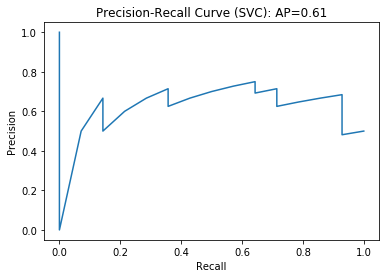

In [10]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(recall, precision)
plt.title('Precision-Recall Curve (SVC): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')

__Random Forest Classifier__<br>

In [11]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=random_state)

# define hyperparameter options
param_grid = {'n_estimators': [200, 500, 1000],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4, 6, 8, 10],
              'criterion' :['gini', 'entropy']
}

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=rfc,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   49.0s finished


Best Score (F1): 0.6045
Best Params:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}


In [12]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss_model = log_loss(y_test, y_proba)
fbeta = fbeta_score(y_test, y_pred, beta=2)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss_model))
print('F2 score: {0:0.2f}'.format(fbeta))
print(classification_report(y_test, y_pred, target_names=target_names))

Average precision-recall score: 0.35
Log loss: 0.10
F2 score: 0.52
              precision    recall  f1-score   support

  Biopsy = 0       0.97      0.98      0.97       201
  Biopsy = 1       0.64      0.50      0.56        14

    accuracy                           0.95       215
   macro avg       0.80      0.74      0.77       215
weighted avg       0.94      0.95      0.95       215



Text(0, 0.5, 'Precision')

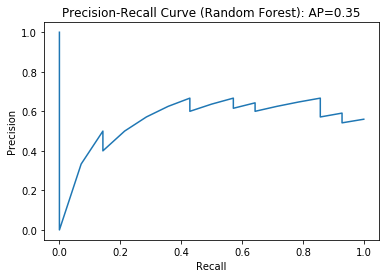

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(recall, precision)
plt.title('Precision-Recall Curve (Random Forest): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')


__K Nearest Neighbors Classifier (k-NN)__<br>

In [14]:
from sklearn.neighbors import KNeighborsClassifier

k_nn = KNeighborsClassifier()

# define hyperparameter options
k_range = list(range(1, 30))
param_grid = dict(n_neighbors=k_range)

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=k_nn,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Best Score (F1): 0.5263
Best Params:  {'n_neighbors': 3}


[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.2s finished


In [15]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss_model = log_loss(y_test, y_proba)
fbeta = fbeta_score(y_test, y_pred, beta=2)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss_model))
print('F2 score: {0:0.2f}'.format(fbeta))
print(classification_report(y_test, y_pred, target_names=target_names))

Average precision-recall score: 0.27
Log loss: 0.86
F2 score: 0.45
              precision    recall  f1-score   support

  Biopsy = 0       0.96      0.98      0.97       201
  Biopsy = 1       0.55      0.43      0.48        14

    accuracy                           0.94       215
   macro avg       0.75      0.70      0.72       215
weighted avg       0.93      0.94      0.94       215



Text(0, 0.5, 'Precision')

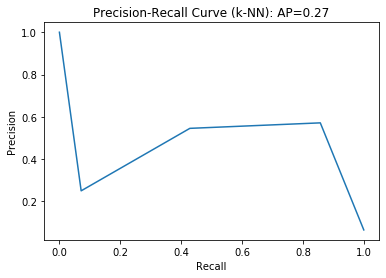

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(recall, precision)
plt.title('Precision-Recall Curve (k-NN): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')

__XG Boost__

In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

# define hyperparameter options
param_grid = {'max_depth': range (2, 10, 1),
              'n_estimators': range(60, 220, 40),
              'learning_rate': [0.1, 0.01, 0.05]
}

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=xgb,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.8s


Best Score (F1): 0.7437
Best Params:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 60}


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    9.7s finished


In [18]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss_model = log_loss(y_test, y_proba)
fbeta = fbeta_score(y_test, y_pred, beta=2)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss_model))
print('F2 score: {0:0.2f}'.format(fbeta))
print(classification_report(y_test, y_pred, target_names=target_names))

Average precision-recall score: 0.61
Log loss: 0.36
F2 score: 0.86
              precision    recall  f1-score   support

  Biopsy = 0       0.99      0.97      0.98       201
  Biopsy = 1       0.65      0.93      0.76        14

    accuracy                           0.96       215
   macro avg       0.82      0.95      0.87       215
weighted avg       0.97      0.96      0.97       215



Text(0, 0.5, 'Precision')

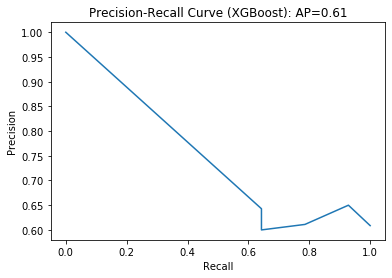

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(recall, precision)
plt.title('Precision-Recall Curve (XGBoost): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')

__XG Boost (with Missing Values)__

In [20]:
# for this model, we will keep all NaN values intact
df_NaN = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df_NaN = df_NaN.replace('?', np.nan)
for column, values in df_NaN.iteritems():
        df_NaN[column] = pd.to_numeric(df_NaN[column], errors='coerce')
#df = df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'], axis=1)
#df = df.fillna(df.median())

# define default random state so that all future random actions will be repeatable
random_state = np.random.RandomState(0)

# define scaler, default feature_range=(0, 1)
scaler = MinMaxScaler()

# split the data into features and target 
X_NaN = df_NaN.drop(['Biopsy'],axis=1)
y_NaN = df_NaN['Biopsy']

# fit and transform scaler in one step for X, y is already normalized
X_NaN_normalized = scaler.fit_transform(X)

# perform stratified test-train split to hold off 25% of normalized data for model validation
X_NaN_train, X_NaN_test, y_NaN_train, y_NaN_test = train_test_split(X_NaN_normalized, y_NaN, test_size=0.25, stratify=y_NaN, random_state=random_state)

In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

# define hyperparameter options
param_grid = {'max_depth': range (2, 10, 1),
              'n_estimators': range(60, 220, 40),
              'learning_rate': [0.1, 0.01, 0.05]
}

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=xgb,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_result = grid.fit(X_NaN_train, y_NaN_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.9s


Best Score (F1): 0.7222
Best Params:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 60}


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    9.7s finished


In [24]:
model = grid_result.best_estimator_
y_NaN_pred = model.predict(X_NaN_test)
y_NaN_proba = model.predict_proba(X_NaN_test)
average_precision = average_precision_score(y_NaN_test, y_NaN_pred)
log_loss_model = log_loss(y_NaN_test, y_NaN_proba)
fbeta = fbeta_score(y_NaN_test, y_NaN_pred, beta=2)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss_model))
print('F2 score: {0:0.2f}'.format(fbeta))
print(classification_report(y_NaN_test, y_NaN_pred, target_names=target_names))

Average precision-recall score: 0.58
Log loss: 0.11
F2 score: 0.81
              precision    recall  f1-score   support

  Biopsy = 0       0.99      0.97      0.98       201
  Biopsy = 1       0.67      0.86      0.75        14

    accuracy                           0.96       215
   macro avg       0.83      0.91      0.86       215
weighted avg       0.97      0.96      0.96       215



Text(0, 0.5, 'Precision')

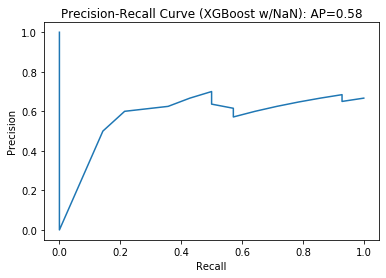

In [25]:
precision, recall, thresholds = precision_recall_curve(y_NaN_test, y_NaN_proba[:,1])

plt.plot(recall, precision)
plt.title('Precision-Recall Curve (XGBoost w/NaN): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')

__Building a DeepLearning Model with Keras__

In [ ]:
# Use scikit-learn to grid search the learning rate and momentum

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Function to create model, required for KerasClassifier

def create_model(neurons=20, dropout=0.3):
    # create model
    
    neurons_2 = int(neurons/2)
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
n_epochs = 300
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=n_epochs)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

# define the grid search parameters
neurons = [20, 40, 100]
dropout = [0.1,0.3,0.5]
batch_size = [32, 64, 128]
param_grid = dict(neurons=neurons, 
                  dropout=dropout, 
                  batch_size=batch_size) 
                  #epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train, callbacks=[es])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Using TensorFlow backend.


In [ ]:
def show_train_history(train_history,n_epochs,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History: %i epochs' % n_epochs)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, n_epochs, step=round(n_epochs/10)))
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
model = create_model(neurons=grid_result.best_params_['neurons'], dropout=grid_result.best_params_['dropout'])
train_history = model.fit(x=X_train, y=y_train,  
                          validation_split=0.25, 
                          epochs=n_epochs, 
                          batch_size=grid_result.best_params_['batch_size'], 
                          verbose=2,
                          callbacks=[es])


In [ ]:
y_pred = model.predict_classes(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss_model = log_loss(y_test, y_proba)
fbeta = fbeta_score(y_test, y_pred, beta=2)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss_model))
print('F2 score: {0:0.2f}'.format(fbeta))
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
show_train_history(train_history,n_epochs,'accuracy','val_accuracy')
show_train_history(train_history,n_epochs,'loss','val_loss')

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision)
plt.title('Precision-Recall Curve (Neural Network): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')

__Step 6: Discussion and Conclusions__<br>

The following can be observed from the data after running the models:
- Logistic Regression, Support Vector Classifier (SVC), and XGBoost performed the best, all producing relatively similar performance (AP=0.61, log loss=0.10) on the validation set.
- The neural network and XGBoost with missing values performed moderately well. More could have been done to optimize the neural network. Here AP>0.66 is achieved by combining a dimensionality reduction and autoencoder neural network. I have not yet learned to implement these techniques.
- Random Forest Classifier and k Nearest Neighbors Classifier (k-NN) performed more poorly. This could be due to overfitting and a loss of generalizability. Perhaps with better hyperparameter optimization, these models could perform better as well.